### 1. Import Libraries

In [1]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

### 2. Inspect the Data

In [2]:
# Inspection function to print out data details
def inspect_step(df, step_name):
    """Helper function to inspect data at each step"""
    print(f"\n{'='*20} {step_name} {'='*20}")
    print(f"Shape: {df.shape}")
    print("\nFirst few rows:")
    print(df.head())
    print("\nData types:")
    print(df.dtypes)
    print("\nMissing values:")
    print(df.isnull().sum())
    print("\nSummary statistics:")
    print(df.describe().round(2))

### 3. Load Data

In [3]:
zip_file_path = 'Network Intrusion.zip'  # Replace with your zip file path
extract_dir = 'network_intrusion_data'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List the extracted files
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)

train_file_path = os.path.join(extract_dir, 'Train_data.csv')
test_file_path = os.path.join(extract_dir, 'Test_data.csv')

# Check if files exist
if os.path.exists(train_file_path) and os.path.exists(test_file_path):
    # Load the datasets
    train_df = pd.read_csv(train_file_path)
    test_df = pd.read_csv(test_file_path)

    # Initial inspection of the training and testing datasets
    inspect_step(train_df, "Training Data Initial Inspection")
    inspect_step(test_df, "Test Data Initial Inspection")
else:
    print("Train_data.csv or Test_data.csv not found in the extracted files.")

Extracted files: ['Test_data.csv', 'Train_data.csv']

==================== Training Data Initial Inspection ====================
Shape: (25192, 42)

First few rows:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_ra

### 4. Handle missing values and encode categorical variables

In [4]:
# Check for missing values
print("\nMissing Values in Training Data:")
print(train_df.isnull().sum())

# Encode categorical variables using Label Encoding
non_numeric_cols = train_df.select_dtypes(include=['object']).columns
non_numeric_cols = non_numeric_cols[non_numeric_cols != 'class']  # Exclude 'class' column
print(f"Non-numeric columns: {non_numeric_cols}")

label_encoders = {}
for col in non_numeric_cols:
    label_encoders[col] = LabelEncoder()
    # Fit the LabelEncoder on both train and test data to ensure all possible values are captured
    combined_data = pd.concat([train_df[col], test_df[col]], axis=0)  # Combine train and test columns
    label_encoders[col].fit(combined_data)
    train_df[col] = label_encoders[col].transform(train_df[col])
    test_df[col] = label_encoders[col].transform(test_df[col])

# Inspect data after encoding
inspect_step(train_df, "Training Data After Encoding")
inspect_step(test_df, "Test Data After Encoding")



Missing Values in Training Data:
duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_

### 5. One-hot encode categorical columns (protocol_type, service, flag)

In [5]:
categorical_cols = ['protocol_type', 'service', 'flag']
missing_cols = [col for col in categorical_cols if col not in train_df.columns]

if missing_cols:
    print(f"Missing columns in train_df: {missing_cols}")
else:
    print(f"Applying one-hot encoding for columns: {categorical_cols}")
    # One-hot encoding for categorical features (e.g., 'protocol_type', 'service', 'flag')
    train_df = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
    test_df = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

# Inspect data after one-hot encoding
inspect_step(train_df, "Training Data After One-Hot Encoding")
inspect_step(test_df, "Test Data After One-Hot Encoding")

# Align the test dataset columns with the train dataset
test_df = test_df.reindex(columns=train_df.columns, fill_value=0)

Applying one-hot encoding for columns: ['protocol_type', 'service', 'flag']

==================== Training Data After One-Hot Encoding ====================
Shape: (25192, 116)

First few rows:
   duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0         0        491          0     0               0       0    0   
1         0        146          0     0               0       0    0   
2         0          0          0     0               0       0    0   
3         0        232       8153     0               0       0    0   
4         0        199        420     0               0       0    0   

   num_failed_logins  logged_in  num_compromised  ...  flag_1  flag_2  flag_3  \
0                  0          0                0  ...   False   False   False   
1                  0          0                0  ...   False   False   False   
2                  0          0                0  ...   False   False   False   
3                  0          1                0  

### 6. Split data into training and testing sets

In [6]:
X = train_df.drop('class', axis=1)  # Features
y = train_df['class']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inspect data after splitting
inspect_step(X_train, "Training Features After Split")
inspect_step(X_test, "Test Features After Split")
inspect_step(y_train, "Training Target After Split")
inspect_step(y_test, "Test Target After Split")



==================== Training Features After Split ====================
Shape: (20153, 115)

First few rows:
       duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
2199          0          8          0     0               0       0    0   
15288         0          0          0     0               0       0    0   
4139          0      16787          0     0               0       0    0   
3505          0          0          0     0               0       0    0   
19281         0          0          0     0               0       0    0   

       num_failed_logins  logged_in  num_compromised  ...  flag_1  flag_2  \
2199                   0          0                0  ...   False   False   
15288                  0          0                0  ...   False   False   
4139                   0          0                0  ...   False   False   
3505                   0          0                0  ...   False   False   
19281                  0          0             

### 7. Scale the features

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inspect scaled features
inspect_step(pd.DataFrame(X_train_scaled, columns=X.columns), "Scaled Training Features")


==================== Scaled Training Features ====================
Shape: (20153, 115)

First few rows:
   duration  src_bytes  dst_bytes      land  wrong_fragment    urgent  \
0 -0.115524  -0.010239  -0.040372 -0.009962        -0.09257 -0.007044   
1 -0.115524  -0.010241  -0.040372 -0.009962        -0.09257 -0.007044   
2 -0.115524  -0.004009  -0.040372 -0.009962        -0.09257 -0.007044   
3 -0.115524  -0.010241  -0.040372 -0.009962        -0.09257 -0.007044   
4 -0.115524  -0.010241  -0.040372 -0.009962        -0.09257 -0.007044   

        hot  num_failed_logins  logged_in  num_compromised  ...    flag_1  \
0 -0.093748          -0.025766  -0.805969        -0.023004  ... -0.310298   
1 -0.093748          -0.025766  -0.805969        -0.023004  ... -0.310298   
2 -0.093748          -0.025766  -0.805969        -0.023004  ... -0.310298   
3 -0.093748          -0.025766  -0.805969        -0.023004  ... -0.310298   
4 -0.093748          -0.025766  -0.805969        -0.023004  ... -0.3102

### 8. Apply SMOTE to handle class imbalance

In [8]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Inspect data after applying SMOTE
inspect_step(pd.DataFrame(X_train_smote, columns=X.columns), "Training Features After SMOTE")
inspect_step(pd.DataFrame(y_train_smote), "Training Target After SMOTE")


==================== Training Features After SMOTE ====================
Shape: (21550, 115)

First few rows:
   duration  src_bytes  dst_bytes      land  wrong_fragment    urgent  \
0 -0.115524  -0.010239  -0.040372 -0.009962        -0.09257 -0.007044   
1 -0.115524  -0.010241  -0.040372 -0.009962        -0.09257 -0.007044   
2 -0.115524  -0.004009  -0.040372 -0.009962        -0.09257 -0.007044   
3 -0.115524  -0.010241  -0.040372 -0.009962        -0.09257 -0.007044   
4 -0.115524  -0.010241  -0.040372 -0.009962        -0.09257 -0.007044   

        hot  num_failed_logins  logged_in  num_compromised  ...    flag_1  \
0 -0.093748          -0.025766  -0.805969        -0.023004  ... -0.310298   
1 -0.093748          -0.025766  -0.805969        -0.023004  ... -0.310298   
2 -0.093748          -0.025766  -0.805969        -0.023004  ... -0.310298   
3 -0.093748          -0.025766  -0.805969        -0.023004  ... -0.310298   
4 -0.093748          -0.025766  -0.805969        -0.023004  ... -0

### 9. Train a Random Forest model

In [9]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

### 10. Evaluate the model

In [10]:
y_pred = rf_model.predict(X_test_scaled)

# Print classification report
print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_pred))



Classification Report on Test Data:
              precision    recall  f1-score   support

     anomaly       1.00      1.00      1.00      2365
      normal       1.00      1.00      1.00      2674

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039



### 11. Plot confusion matrix

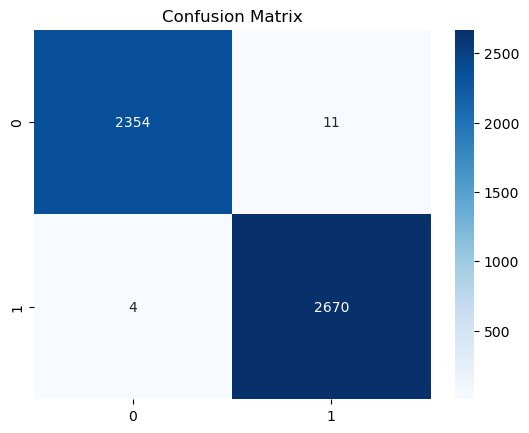

In [11]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

### 12. Feature importance visualization

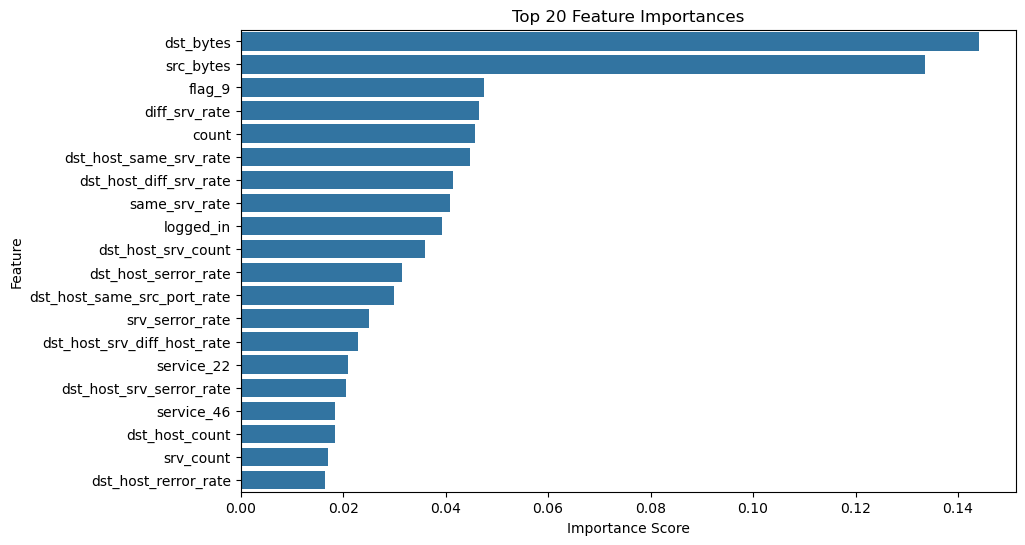

In [12]:
feature_importances = rf_model.feature_importances_
sorted_idx = feature_importances.argsort()[::-1]
sorted_features = X.columns[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Plot top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances[:20], y=sorted_features[:20], orient='h')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()